In [ ]:
!pip install transformers[torch]
!pip install datasets==2.18.0
!pip install scikit-learn
!pip install huggingface_hub
!pip install pandas
!pip install matplotlib
!pip install torch
!pip install umap-learn

In [1]:
from datasets import list_datasets

In [ ]:
all_datasets=list_datasets()
print(f" The number of datasets exists is {len(all_datasets)}")

<ipython-input-3-2d82d505800b>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets=list_datasets()
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


 The number of datasets exists is 351087


In [2]:
from datasets import load_dataset
emotions=load_dataset("dair-ai/emotion",trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotions["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [ ]:
emotions["train"].column_names

['text', 'label']

In [ ]:
emotions["train"]["text"][:2]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake']

In [ ]:
emotions["train"]["label"][:2]

[0, 0]

In [ ]:
import pandas as pd
emotions.set_format(type="pandas")
df= emotions["train"][:]
df.tail()

,text,label
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3
15999,i know a lot but i feel so stupid because i ca...,0


In [ ]:
def convert_label_int_2_string(row):
  return emotions["train"].features["label"].int2str(row)

In [ ]:
df["label_name"]=df["label"].apply(convert_label_int_2_string)

In [40]:
df.head(10)

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
5,ive been feeling a little burdened lately wasn...,0,sadness
6,ive been taking or milligrams or times recomme...,5,surprise
7,i feel as confused about life as a teenager or...,4,fear
8,i have been with petronas for years i feel tha...,1,joy
9,i feel romantic too,2,love


<Axes: ylabel='label_name'>

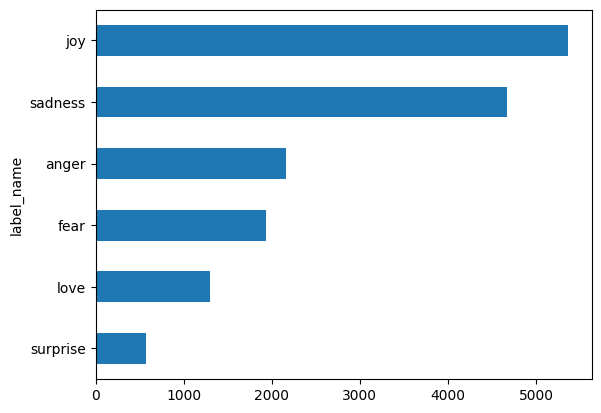

In [ ]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()

In [ ]:
text="My name is kareem"
tokenized_text=list(text)
tokenized_text

['M',
 'y',
 ' ',
 'n',
 'a',
 'm',
 'e',
 ' ',
 'i',
 's',
 ' ',
 'k',
 'a',
 'r',
 'e',
 'e',
 'm']

In [ ]:
token2index={ch:index for index,ch in enumerate(sorted(set(tokenized_text)))}
token2index

{' ': 0,
 'M': 1,
 'a': 2,
 'e': 3,
 'i': 4,
 'k': 5,
 'm': 6,
 'n': 7,
 'r': 8,
 's': 9,
 'y': 10}

In [8]:
from transformers import AutoTokenizer
model_ckp="distilbert-base-uncased"
token_access=""
tokenizer=AutoTokenizer.from_pretrained(model_ckp,token=token_access)

In [ ]:
encoded_text=tokenizer(text)

In [ ]:
encoded_text

{'input_ids': [101, 2026, 2171, 2003, 10556, 9910, 2213, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokens=tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

In [ ]:
tokens

['[CLS]', 'my', 'name', 'is', 'ka', '##ree', '##m', '[SEP]']

In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] my name is kareem [SEP]


In [ ]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [ ]:
tokenizer.model_max_length

512

In [5]:
def tokenize(batch):
  # print(batch["text"])
  return tokenizer(batch["text"],padding=True,truncation=True)

In [ ]:
emotions

In [9]:
emotion_encoded=emotions.map(tokenize,batched=True,batch_size=None)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotion_encoded.column_names

{'train': ['text', 'label', 'input_ids', 'attention_mask'],
 'validation': ['text', 'label', 'input_ids', 'attention_mask'],
 'test': ['text', 'label', 'input_ids', 'attention_mask']}

In [10]:
#Using pretrained models
from transformers import AutoModel
import torch
model_chk="distilbert-base-uncased"
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=AutoModel.from_pretrained(model_chk).to(device)

In [11]:
# Feature extraction function
def extract_hidden_states(batch):



    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [12]:
emotion_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])



In [13]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [42]:
!pip install numpy==1.26.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 61.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [14]:
#hide_output
emotions_hidden = emotion_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [15]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [17]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.635

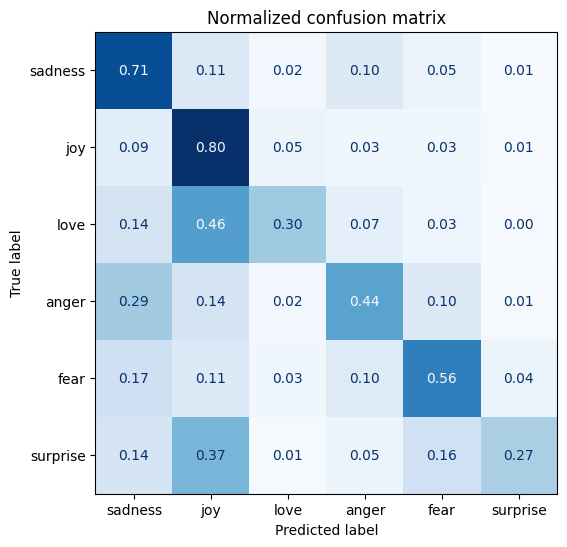

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
labels = emotions["train"].features["label"].names
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [19]:
# hide_output
from transformers import AutoModelForSequenceClassification
token_access_write=""
num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_chk, num_labels=num_labels,token=token_access_write)
         .to(device))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [21]:
from huggingface_hub import notebook_login

notebook_login()

In [22]:

from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotion_encoded["train"]) // batch_size
model_name = f"{model_chk}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotion_encoded["train"],
                  eval_dataset=emotion_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

<ipython-input-23-bf3f856b3117>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abanna to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.833800,0.308388,0.907000,0.906825
2,0.253000,0.221850,0.924500,0.924305


In [ ]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")

events.out.tfevents.1705491928.513cef6be2db.1776.0:   0%|          | 0.00/5.84k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/abedbanna/distilbert-base-uncased-finetuned-emotion/commit/d4a6126969663d75878dfba07784c387044196c0', commit_message='Training completed!', commit_description='', oid='d4a6126969663d75878dfba07784c387044196c0', pr_url=None, pr_revision=None, pr_num=None)